# RCNN

Building from model name arguments...


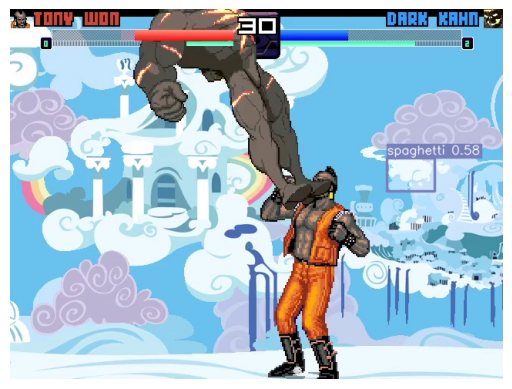

-

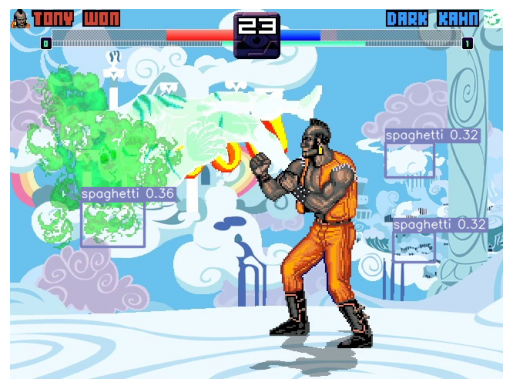

-

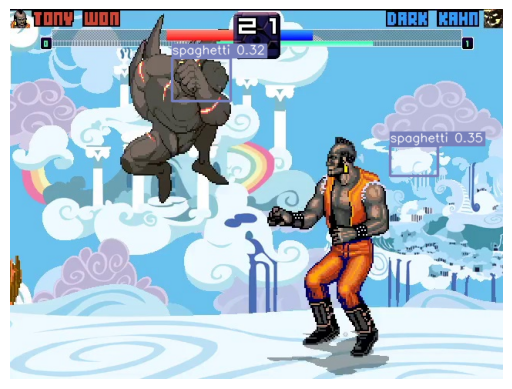

-

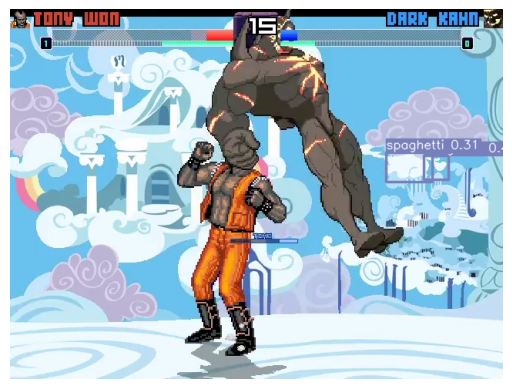

-

KeyboardInterrupt: 

In [1]:
import numpy as np
import cv2
import torch
import glob as glob
import os
import time
import argparse
import yaml
import matplotlib.pyplot as plt
import sys

sys.path.insert(0, 'ObjectDetection-FasterRCNN-master')
from models.create_fasterrcnn_model import create_model
from utils.annotations import inference_annotations
from utils.general import set_infer_dir
from utils.transforms import infer_transforms, resize

import os
import subprocess
import requests
from random import choice
import cv2
import streamlink

import os
import subprocess
import requests
from random import choice
import cv2
import streamlink

from google.cloud import storage

service_account_file = 'master-magnet-414308-23a8bbb0c34f.json'
storage_client = storage.Client.from_service_account_json(service_account_file)

def upload_to_bucket(blob_name, content, bucket_name):
    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(blob_name)
    blob.upload_from_filename(content)
    
def repeat():
    #%%time

    # Get the image file name for saving output later on.
    image_name = test_image.split(os.path.sep)[-1].split('.')[0]
    orig_image = cv2.imread(test_image)
    frame_height, frame_width, _ = orig_image.shape
    
    RESIZE_TO = frame_width
    # orig_image = image.copy()
    image_resized = resize(orig_image, RESIZE_TO)
    image = image_resized.copy()
    # BGR to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = infer_transforms(image)
    # Add batch dimension.
    image = torch.unsqueeze(image, 0)
    start_time = time.time()
    with torch.no_grad():
        outputs = model(image.to(DEVICE))
    end_time = time.time()
    
    # Get the current fps.
    fps = 1 / (end_time - start_time)
    # Add `fps` to `total_fps`.
    #total_fps += fps
    # Increment frame count.
    #frame_count += 1
    # Load all detection to CPU for further operations.
    outputs = [{k: v.to('cpu') for k, v in t.items()} for t in outputs]
    # Carry further only if there are detected boxes.
    if len(outputs[0]['boxes']) != 0:
        orig_image = inference_annotations(
            outputs, 
            detection_threshold, 
            CLASSES,
            COLORS, 
            orig_image, 
            image_resized,
            args
        )
        if args['show_image']:
            cv2.imshow('Prediction', orig_image)
            cv2.waitKey(1)
        if args['mpl_show']:
            plt.imshow(orig_image[:, :, ::-1])
            plt.axis('off')
            plt.show()
    cv2.imwrite(f"./infer_image.jpg", orig_image)
    #print(f"Image done...")
    #print('-'*50)
    
    #print('TEST PREDICTIONS COMPLETE')
    #cv2.destroyAllWindows()
    # Calculate and print the average FPS.
    #avg_fps = total_fps / frame_count
    #print(f"Average FPS: {avg_fps:.3f}")
    print('-', end='')
    
def fetch_content_from_gcs(link):
    alp = list(map(chr, range(97, 123)))
    link = link + "?"+choice(alp)+choice(alp)+'='+choice(alp)+choice(alp)
    try:
        response = requests.get(link)
        if response.status_code == 200:
            return response.text
        else:
            return f"Error fetching content. Status code: {response.status_code}"
    except requests.RequestException as e:
        return f"Error: {e}"

args = {}
args['input'] = './output_image.jpg' # set by user per inference

args['config'] = None
args['model']= None
args['weights'] = '/mnt/c/Users/edwar/OneDrive - UTS/jupyter notebooks/42028/3dprintfail/best_model.pth'
args['mpl_show'] = None
args['mpl_show'] = True
args['device']=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
args['img_size'] = None
args['threshold'] = 0.3
args['no_labels'] = None
args['show_image'] = None

data_configs = None
DEVICE = args['device']
OUT_DIR = set_infer_dir()

checkpoint = torch.load(args['weights'], map_location=DEVICE)
# If config file is not given, load from model dictionary.
if data_configs is None:
    data_configs = True
    NUM_CLASSES = checkpoint['config']['NC']
    CLASSES = checkpoint['config']['CLASSES']
try:
    print('Building from model name arguments...')
    build_model = create_model[str(args['model'])]
except:
    build_model = create_model[checkpoint['model_name']]
model = build_model(num_classes=NUM_CLASSES, coco_model=False)
model.load_state_dict(checkpoint['model_state_dict'])

model.to(DEVICE).eval()

COLORS = np.random.uniform(0, 255, size=(len(CLASSES), 3))

test_image = args['input']
# Define the detection threshold any detection having
# score below this will be discarded.
detection_threshold = args['threshold']

# To count the total number of frames iterated through.
frame_count = 0
# To keep adding the frames' FPS.
total_fps = 0

gcs_link = "https://storage.googleapis.com/dl_cnn_a3_3dprintfail/link.txt"
while True:
    content = fetch_content_from_gcs(gcs_link)
    streams = streamlink.streams(content)
    #streams = streamlink.streams('https://www.twitch.tv/saltybet')
    if "best" not in streams.keys():
        continue
    
    stream_url = streams["best"].url
        
    vcap = cv2.VideoCapture(stream_url)
    image = vcap.read()[1]
    cv2.imwrite('output_image.jpg', image)

    #change this to be an in-process function where the model can be kept in memory, ideally yolo for faster inferencing
    repeat()
    #subprocess.run(['python3', 'ObjectDetection-FasterRCNN-master/inference.py','--input','./output_image.jpg','--weights','./best_model.pth'])
    
    #foo = len(os.listdir('outputs/inference'))
    upload_to_bucket('infer_image.jpg', './infer_image.jpg', 'dl_cnn_a3_3dprintfail')

# YOLO

In [3]:
import cv2, requests, streamlink
from random import choice
from google.cloud import storage
from ultralytics import YOLO

image_path_input = 'output_image.jpg'
image_path_output = 'infer_image.jpg'
model = YOLO('yoloweights.pt')
service_account_file = 'master-magnet-414308-23a8bbb0c34f.json'
storage_client = storage.Client.from_service_account_json(service_account_file)

def upload_to_bucket(blob_name, content, bucket_name):
    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(blob_name)
    blob.upload_from_filename(content)
    
def fetch_content_from_gcs(link):
    alp = list(map(chr, range(97, 123)))
    link = link + "?"+choice(alp)+choice(alp)+'='+choice(alp)+choice(alp)
    try:
        response = requests.get(link)
        if response.status_code == 200:
            return response.text
        else:
            return f"Error fetching content. Status code: {response.status_code}"
    except requests.RequestException as e:
        return f"Error: {e}"

gcs_link = "https://storage.googleapis.com/dl_cnn_a3_3dprintfail/link.txt"
while True:
    content = fetch_content_from_gcs(gcs_link)
    streams = streamlink.streams(content)
    if "best" not in streams.keys():
        continue
    
    stream_url = streams["best"].url
        
    vcap = cv2.VideoCapture(stream_url)
    image = vcap.read()[1]
    cv2.imwrite(image_path_input, image)

    results = model(image_path_input)
    cv2.imwrite(image_path_output, results[0].plot())

    upload_to_bucket('infer_image.jpg', f'./{image_path_output}', 'dl_cnn_a3_3dprintfail')

KeyboardInterrupt: 

In [ ]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
image_path_input = 'output_image.jpg'
image_path_output = 'infer_image.jpg'
model = YOLO('yoloweights.pt')

In [ ]:
results = model(image_path_input)
plt.imsave('infer_image.jpg', results[0].plot())

# Old

In [ ]:
#%pip install streamlink
#%pip install ffmpeg
#to avoid:
#ImportError: cannot import name 'storage' from 'google.cloud' (unknown location)
#%pip install --upgrade google-cloud-storage

In [ ]:
import os
from google.oauth2 import service_account

# Path to your service account JSON file
service_account_file = 'master-magnet-414308-23a8bbb0c34f.json'

# Load credentials from the JSON file
credentials = service_account.Credentials.from_service_account_file(service_account_file)

# Now you can use the credentials to authenticate with GCP services
# For example, using the BigQuery client library:
#from google.cloud import bigquery

#client = bigquery.Client(credentials=credentials, project='your-project-id')
# Use the client to run BigQuery queries or other GCP operations
credentials

In [ ]:
from google.cloud import storage

# Path to your service account JSON file
service_account_file = 'master-magnet-414308-23a8bbb0c34f.json'

# Initialize the storage client with service account credentials
storage_client = storage.Client.from_service_account_json(service_account_file)

In [ ]:
from google.cloud import storage

service_account_file = 'master-magnet-414308-23a8bbb0c34f.json'
storage_client = storage.Client.from_service_account_json(service_account_file)

def upload_to_bucket(blob_name, content, bucket_name):
    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(blob_name)
    blob.upload_from_filename(content)

#upload_to_bucket('link.txt', 'https://www.twitch.tv/aa', 'dl_cnn_a3_3dprintfail')

In [ ]:
def upload_to_bucket(blob_name, content, bucket_name):
    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(blob_name)
    blob.upload_from_filename(content)
upload_to_bucket('infer_image.jpg', 'infer_image.jpg', 'dl_cnn_a3_3dprintfail')

In [ ]:
import requests
from random import choice

def fetch_content_from_gcs(link):
    alp = list(map(chr, range(97, 123)))
    link = link + "?"+choice(alp)+choice(alp)+'='+choice(alp)+choice(alp)
    try:
        response = requests.get(link)
        if response.status_code == 200:
            return response.text
        else:
            return f"Error fetching content. Status code: {response.status_code}"
    except requests.RequestException as e:
        return f"Error: {e}"

gcs_link = "https://storage.googleapis.com/dl_cnn_a3_3dprintfail/link.txt"
content = fetch_content_from_gcs(gcs_link)
#gcs_link
content

In [ ]:
import streamlink
import cv2
from matplotlib import pyplot as plt
import requests

def fetch_content_from_gcs(link):
    try:
        response = requests.get(link)
        if response.status_code == 200:
            return response.text
        else:
            return f"Error fetching content. Status code: {response.status_code}"
    except requests.RequestException as e:
        return f"Error: {e}"

gcs_link = "https://storage.googleapis.com/dl_cnn_a3_3dprintfail/link.txt"
content = fetch_content_from_gcs(gcs_link)
content
streams = streamlink.streams(content)
print(streams.keys())
if "best" in streams.keys():
    stream_url = streams["best"].url
    streams.keys()
else:
    print('no')
    #continue

In [ ]:
vcap = cv2.VideoCapture(stream_url)
image = vcap.read()[1]
cv2.imwrite('output_image.jpg', image)

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
import os
import subprocess

vcap = cv2.VideoCapture(stream_url)
image = vcap.read()[1]
cv2.imwrite('output_image.jpg', image)

subprocess.run(['python3', 'ObjectDetection-FasterRCNN-master/inference.py','--input','./output_image.jpg','--weights','./best_model.pth'])

foo = len(os.listdir('outputs/inference'))
#'./outputs/inference/res_{foo}/output_image.jpg'
image = cv2.imread(f'./outputs/inference/res_{foo}/output_image.jpg', cv2.IMREAD_COLOR)
cv2.imwrite('infer_image.jpg', image)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
import numpy as np
import cv2
import torch
import glob as glob
import os
import time
import argparse
import yaml
import matplotlib.pyplot as plt
import sys

sys.path.insert(0, 'ObjectDetection-FasterRCNN-master')
from models.create_fasterrcnn_model import create_model
from utils.annotations import inference_annotations
from utils.general import set_infer_dir
from utils.transforms import infer_transforms, resize

import os
import subprocess
import requests
from random import choice
import cv2
import streamlink

import os
import subprocess
import requests
from random import choice
import cv2
import streamlink

from google.cloud import storage

service_account_file = 'master-magnet-414308-23a8bbb0c34f.json'
storage_client = storage.Client.from_service_account_json(service_account_file)

def upload_to_bucket(blob_name, content, bucket_name):
    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(blob_name)
    blob.upload_from_filename(content)
    
def repeat():
    #%%time

    # Get the image file name for saving output later on.
    image_name = test_image.split(os.path.sep)[-1].split('.')[0]
    orig_image = cv2.imread(test_image)
    frame_height, frame_width, _ = orig_image.shape
    
    RESIZE_TO = frame_width
    # orig_image = image.copy()
    image_resized = resize(orig_image, RESIZE_TO)
    image = image_resized.copy()
    # BGR to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = infer_transforms(image)
    # Add batch dimension.
    image = torch.unsqueeze(image, 0)
    start_time = time.time()
    with torch.no_grad():
        outputs = model(image.to(DEVICE))
    end_time = time.time()
    
    # Get the current fps.
    fps = 1 / (end_time - start_time)
    # Add `fps` to `total_fps`.
    #total_fps += fps
    # Increment frame count.
    #frame_count += 1
    # Load all detection to CPU for further operations.
    outputs = [{k: v.to('cpu') for k, v in t.items()} for t in outputs]
    # Carry further only if there are detected boxes.
    if len(outputs[0]['boxes']) != 0:
        orig_image = inference_annotations(
            outputs, 
            detection_threshold, 
            CLASSES,
            COLORS, 
            orig_image, 
            image_resized,
            args
        )
        if args['show_image']:
            cv2.imshow('Prediction', orig_image)
            cv2.waitKey(1)
        if args['mpl_show']:
            plt.imshow(orig_image[:, :, ::-1])
            plt.axis('off')
            plt.show()
    cv2.imwrite(f"./infer_image.jpg", orig_image)
    #print(f"Image done...")
    #print('-'*50)
    
    #print('TEST PREDICTIONS COMPLETE')
    #cv2.destroyAllWindows()
    # Calculate and print the average FPS.
    #avg_fps = total_fps / frame_count
    #print(f"Average FPS: {avg_fps:.3f}")
    print('-', end='')
    
def fetch_content_from_gcs(link):
    alp = list(map(chr, range(97, 123)))
    link = link + "?"+choice(alp)+choice(alp)+'='+choice(alp)+choice(alp)
    try:
        response = requests.get(link)
        if response.status_code == 200:
            return response.text
        else:
            return f"Error fetching content. Status code: {response.status_code}"
    except requests.RequestException as e:
        return f"Error: {e}"

args = {}
args['input'] = './output_image.jpg' # set by user per inference

args['config'] = None
args['model']= None
args['weights'] = '/mnt/c/Users/edwar/OneDrive - UTS/jupyter notebooks/42028/3dprintfail/best_model.pth'
args['mpl_show'] = None
args['mpl_show'] = True
args['device']=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
args['img_size'] = None
args['threshold'] = 0.3
args['no_labels'] = None
args['show_image'] = None

data_configs = None
DEVICE = args['device']
OUT_DIR = set_infer_dir()

checkpoint = torch.load(args['weights'], map_location=DEVICE)
# If config file is not given, load from model dictionary.
if data_configs is None:
    data_configs = True
    NUM_CLASSES = checkpoint['config']['NC']
    CLASSES = checkpoint['config']['CLASSES']
try:
    print('Building from model name arguments...')
    build_model = create_model[str(args['model'])]
except:
    build_model = create_model[checkpoint['model_name']]
model = build_model(num_classes=NUM_CLASSES, coco_model=False)
model.load_state_dict(checkpoint['model_state_dict'])

model.to(DEVICE).eval()

COLORS = np.random.uniform(0, 255, size=(len(CLASSES), 3))

test_image = args['input']
# Define the detection threshold any detection having
# score below this will be discarded.
detection_threshold = args['threshold']

# To count the total number of frames iterated through.
frame_count = 0
# To keep adding the frames' FPS.
total_fps = 0

gcs_link = "https://storage.googleapis.com/dl_cnn_a3_3dprintfail/link.txt"
while True:
    content = fetch_content_from_gcs(gcs_link)
    streams = streamlink.streams(content)
    #streams = streamlink.streams('https://www.twitch.tv/saltybet')
    if "best" not in streams.keys():
        continue
    
    stream_url = streams["best"].url
        
    vcap = cv2.VideoCapture(stream_url)
    image = vcap.read()[1]
    cv2.imwrite('output_image.jpg', image)

    #change this to be an in-process function where the model can be kept in memory, ideally yolo for faster inferencing
    repeat()
    #subprocess.run(['python3', 'ObjectDetection-FasterRCNN-master/inference.py','--input','./output_image.jpg','--weights','./best_model.pth'])
    
    #foo = len(os.listdir('outputs/inference'))
    upload_to_bucket('infer_image.jpg', './infer_image.jpg', 'dl_cnn_a3_3dprintfail')